In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")

In [2]:
filename = 'Data/gz_home_data1.csv'
data = pd.read_csv(filename)

# 查看基本信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   标题                                                                    5 non-null      object 
 1   地区                                                                    5 non-null      object 
 2   位置                                                                    5 non-null      object 
 3   具体位置                                                                  5 non-null      object 
 4   resblock-tag1_resblock-tag_resblock-type_resblock-tag2_resblock-tag3  5 non-null      object 
 5   均价/平方米每元                                                              5 non-null      object 
 6   总价                                                                    3 non-null      object 
 7   类型 

In [3]:
# 随机抽取数据，查看具体情况
data.sample(5)

,标题,地区,位置,具体位置,resblock-tag1_resblock-tag_resblock-type_resblock-tag2_resblock-tag3,均价/平方米每元,总价,类型,室厅数,面积,Unnamed: 10
2,国化广场,白云,白云大道南,广东省广州市白云区云城北二路116号,"商业类,车位充足,人车分流,近地铁,地铁沿线",价格待定,NaN,待售,NaN,NaN,NaN
1,时代印记,黄埔,知识城,广东省广州市黄埔区亨美西路,"住宅,低单价,低总价,绿化率高,人车分流",18000,总价155-245(万/套),在售,"3室,4室",建面 87-136㎡,NaN
3,富豪山庄·领峰,番禺,富豪山庄,番禺区东环街市广路232号富豪大厦,"住宅,低单价,低总价,车位充足,低密居所",30000,总价159-321(万/套),在售,1室,建面 53-107㎡,NaN
4,北大科技园·国际科创广场,白云,石井,石沙公路81号,"商业类,小型社区,近地铁,地铁沿线,综合商场",价格待定,NaN,待售,NaN,NaN,NaN
0,星河湾萝峰,黄埔,香雪,广东省广州市黄埔区萝岗路与启学路交叉口北200米,"住宅,车位充足,绿化率高,品牌房企,入户花园",38000,总价480-1550(万/套),在售,"3室,5室",建面 130-265㎡,NaN


In [4]:
# 修改列名
data.rename(columns={'resblock-tag1_resblock-tag_resblock-type_resblock-tag2_resblock-tag3':'标签'},inplace=True)

data = data[['标题','地区','具体位置','类型','均价/平方米每元','室厅数','面积','标签','总价']]

In [5]:
# 查看各列缺失值
data.isnull().sum()

标题          0
地区          0
具体位置        0
类型          0
均价/平方米每元    0
室厅数         2
面积          2
标签          0
总价          2
dtype: int64

In [6]:
# 查看数据中的字段大概内容
summary = {
    '标题':[data['标题'].nunique()],
    '类型':list(data['类型'].unique()),
    '具体位置':[data['具体位置'].nunique()],
    '地区':list(data['地区'].unique()),
    '室厅数':list(data['室厅数'].unique()),
}

df = pd.DataFrame.from_dict(summary,orient='index').T
df = df.fillna('')
df

# 删除其中的错误数据，此步骤可以忽略，这是由于作者数据集问题所造成的，在后面才发现，返回来修改
# print(data['类型'].unique())     # ['在售' '待售' '售罄']
index_to_drop = data.loc[data['类型']=='售罄'].index
data = data.drop(index_to_drop)

In [7]:
# 处理均价字段缺失值,以及异常字段
data['均价/平方米每元'] = data['均价/平方米每元'].replace('价格待定',0)

# 此步骤可以忽视，这是为了删除其中一个特殊的值，防止报错，方法一。
index_drop = data.loc[data['均价/平方米每元']=='112-175'].index
data.drop(data.loc[data['均价/平方米每元']=='800-1600'].index,inplace=True)
data.drop(index_drop,inplace=True)
# 方法二
# data['均价/平方米每元'] = data['均价/平方米每元'].astype(str)
# def delete(datas):
#     if '-' in datas:
#         data.drop(datas,inplace=True)
#     else:
#         pass
# data['均价/平方米每元'] = data['均价/平方米每元'].apply(delete)

# 使用中位数代替数据中的空值
data['均价/平方米每元'] = data['均价/平方米每元'].astype(float)
medians = data['均价/平方米每元'].median()
data['均价/平方米每元'] = data['均价/平方米每元'].replace(0,medians)


In [8]:
# 处理室厅数字段，由于数据量较少，所以选择填充数据，在这里选择使用众数填充
data['室厅数'].value_counts()
data['室厅数'].fillna('3室,4室',inplace=True)

# 对于不确定的室厅数，计算平均值作为代表
def process_room(room):
    room = room.replace('室','').strip()
    if ',' in room:
        mins, maxs = map(float, room.split(','))
        return int((mins + maxs)/2)
    return int(room)
data['室厅数'] = data['室厅数'].apply(process_room)

data.sample(5)

,标题,地区,具体位置,类型,均价/平方米每元,室厅数,面积,标签,总价
0,星河湾萝峰,黄埔,广东省广州市黄埔区萝岗路与启学路交叉口北200米,在售,38000.0,4,建面 130-265㎡,"住宅,车位充足,绿化率高,品牌房企,入户花园",总价480-1550(万/套)
4,北大科技园·国际科创广场,白云,石沙公路81号,待售,18000.0,3,NaN,"商业类,小型社区,近地铁,地铁沿线,综合商场",NaN
3,富豪山庄·领峰,番禺,番禺区东环街市广路232号富豪大厦,在售,30000.0,1,建面 53-107㎡,"住宅,低单价,低总价,车位充足,低密居所",总价159-321(万/套)
2,国化广场,白云,广东省广州市白云区云城北二路116号,待售,18000.0,3,NaN,"商业类,车位充足,人车分流,近地铁,地铁沿线",NaN
1,时代印记,黄埔,广东省广州市黄埔区亨美西路,在售,18000.0,3,建面 87-136㎡,"住宅,低单价,低总价,绿化率高,人车分流",总价155-245(万/套)


In [9]:
# 处理面积字段，并取中位数作为结果
data['面积'] = data['面积'].astype(str)

def process_area(area):
    area = area.replace('建面','').strip()
    area = area.replace('㎡','').strip()
    if "-" in area:
        area_min, area_max = map(float, area.split('-'))
        return (area_min + area_max) / 2
    return float(area)

data['面积'] = data['面积'].apply(process_area)

area_average = int(data['面积'].median())
print(area_average)
data['面积'].fillna(area_average,inplace=True)

data.sample(5)

111


,标题,地区,具体位置,类型,均价/平方米每元,室厅数,面积,标签,总价
1,时代印记,黄埔,广东省广州市黄埔区亨美西路,在售,18000.0,3,111.5,"住宅,低单价,低总价,绿化率高,人车分流",总价155-245(万/套)
2,国化广场,白云,广东省广州市白云区云城北二路116号,待售,18000.0,3,111.0,"商业类,车位充足,人车分流,近地铁,地铁沿线",NaN
0,星河湾萝峰,黄埔,广东省广州市黄埔区萝岗路与启学路交叉口北200米,在售,38000.0,4,197.5,"住宅,车位充足,绿化率高,品牌房企,入户花园",总价480-1550(万/套)
3,富豪山庄·领峰,番禺,番禺区东环街市广路232号富豪大厦,在售,30000.0,1,80.0,"住宅,低单价,低总价,车位充足,低密居所",总价159-321(万/套)
4,北大科技园·国际科创广场,白云,石沙公路81号,待售,18000.0,3,111.0,"商业类,小型社区,近地铁,地铁沿线,综合商场",NaN


In [10]:
# 处理总价字段，使用中位数作为最后的总价数
data['总价'] = data['总价'].astype(str)

def process_total(total):
    total = total.replace('总价','').strip()
    total = total.replace("(万/套)",'').strip()
    if '-' in total:
        total_min, total_max = map(float, total.split('-'))
        return (total_min + total_max) / 2
    return float(total)

data['总价'] = data['总价'].apply(process_total)

# 使用中位数填充总价字段的缺失值
total_median = data['总价'].median()
print(total_median)
data['总价'].fillna(total_median,inplace=True)

data.sample(5)

240.0


,标题,地区,具体位置,类型,均价/平方米每元,室厅数,面积,标签,总价
3,富豪山庄·领峰,番禺,番禺区东环街市广路232号富豪大厦,在售,30000.0,1,80.0,"住宅,低单价,低总价,车位充足,低密居所",240.0
4,北大科技园·国际科创广场,白云,石沙公路81号,待售,18000.0,3,111.0,"商业类,小型社区,近地铁,地铁沿线,综合商场",240.0
1,时代印记,黄埔,广东省广州市黄埔区亨美西路,在售,18000.0,3,111.5,"住宅,低单价,低总价,绿化率高,人车分流",200.0
2,国化广场,白云,广东省广州市白云区云城北二路116号,待售,18000.0,3,111.0,"商业类,车位充足,人车分流,近地铁,地铁沿线",240.0
0,星河湾萝峰,黄埔,广东省广州市黄埔区萝岗路与启学路交叉口北200米,在售,38000.0,4,197.5,"住宅,车位充足,绿化率高,品牌房企,入户花园",1015.0


In [11]:
data.describe()

,均价/平方米每元,室厅数,面积,总价
count,5.000000,5.000000,5.000000,5.000000
mean,24400.000000,2.800000,122.200000,387.000000
std,9208.691547,1.095445,44.204921,351.489687
min,18000.000000,1.000000,80.000000,200.000000
25%,18000.000000,3.000000,111.000000,240.000000
50%,18000.000000,3.000000,111.000000,240.000000
75%,30000.000000,3.000000,111.500000,240.000000
max,38000.000000,4.000000,197.500000,1015.000000


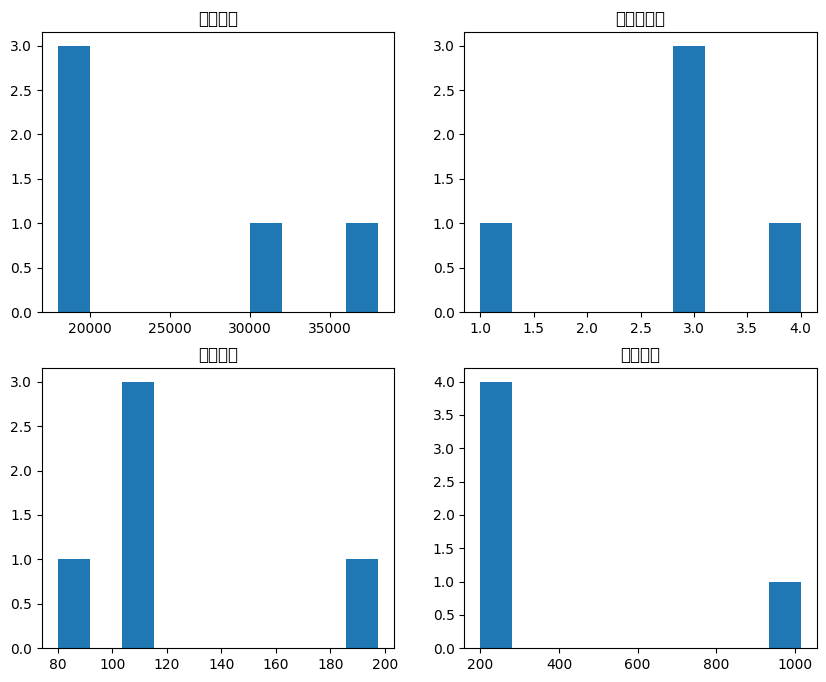

In [12]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.hist(data['均价/平方米每元'])
plt.title('均价分布')

plt.subplot(2,2,2)
plt.hist(data['室厅数'])
plt.title('室厅数分布')

plt.subplot(2,2,3)
plt.hist(data['面积'])
plt.title('面积分布')

plt.subplot(2,2,4)
plt.hist(data['总价'])
plt.title('总价分布')

plt.show()

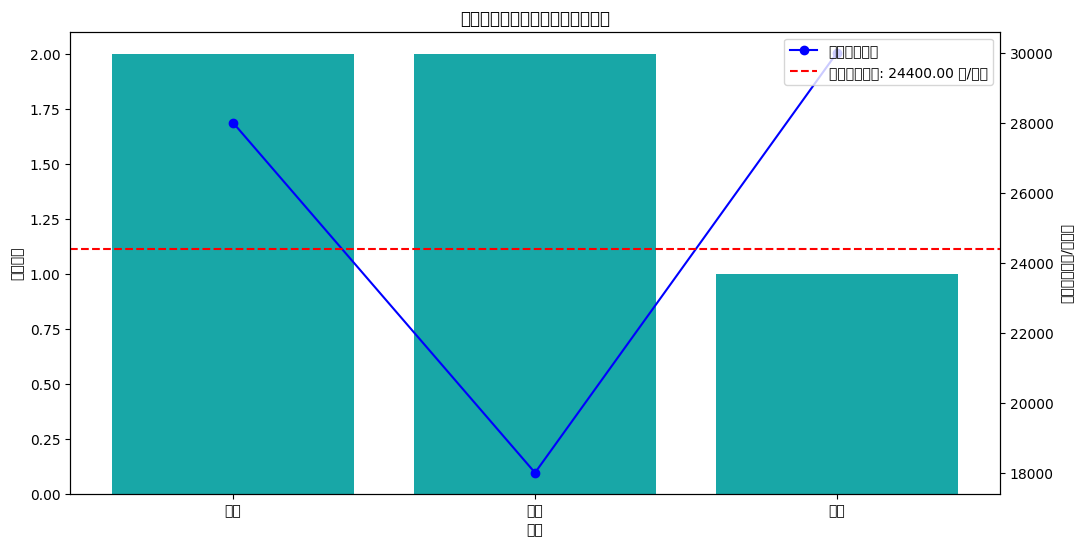

In [13]:
# 计算各地区的小区数量，并按降序排列
region_order = data['地区'].value_counts().index
# print(region_order)

# 计算各行政区的平均单价，按新的顺序对平均单价排序
average_price1 = data.groupby('地区')['均价/平方米每元'].mean()
average_price1 = average_price1.reindex(region_order)
# print(average_price1)

# 计算总体平均单价
overall_average_price = data['均价/平方米每元'].mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

# 按降序排列绘制小区数量的柱状图
sns.countplot(data=data, x='地区', order=region_order, ax=ax1, color='c')
ax1.set_xlabel('地区')
ax1.set_ylabel('小区数量')
ax1.tick_params(axis='x')

# 创建第二个坐标轴，用于绘制各个行政区的单价折线图
ax2 = ax1.twinx()
ax2.plot(average_price1.index, average_price1.values, color='b', marker='o', linestyle='-',label='各区平均单价')
ax2.set_ylabel('平均单价（元/平米）')

# 标出总体平均单价
ax2.axhline(overall_average_price, color='r', linestyle='--', label=f'总体平均单价: {overall_average_price:.2f} 元/平米')
ax2.legend(loc='upper right')

plt.title('不同行政区的楼盘数量和平均单价')
plt.show()

In [14]:
# 提取小区标签并统计出现次数
tags = data['标签'].str.split(',').explode()
tag_counts = Counter(tags)
print(tag_counts)


Counter({'住宅': 3, '车位充足': 3, '绿化率高': 2, '低单价': 2, '低总价': 2, '人车分流': 2, '商业类': 2, '近地铁': 2, '地铁沿线': 2, '品牌房企': 1, '入户花园': 1, '低密居所': 1, '小型社区': 1, '综合商场': 1})


Counter({'住宅': 3, '车位充足': 3, '绿化率高': 2, '低单价': 2, '低总价': 2, '人车分流': 2, '商业类': 2, '近地铁': 2, '地铁沿线': 2, '品牌房企': 1, '入户花园': 1, '低密居所': 1, '小型社区': 1, '综合商场': 1})


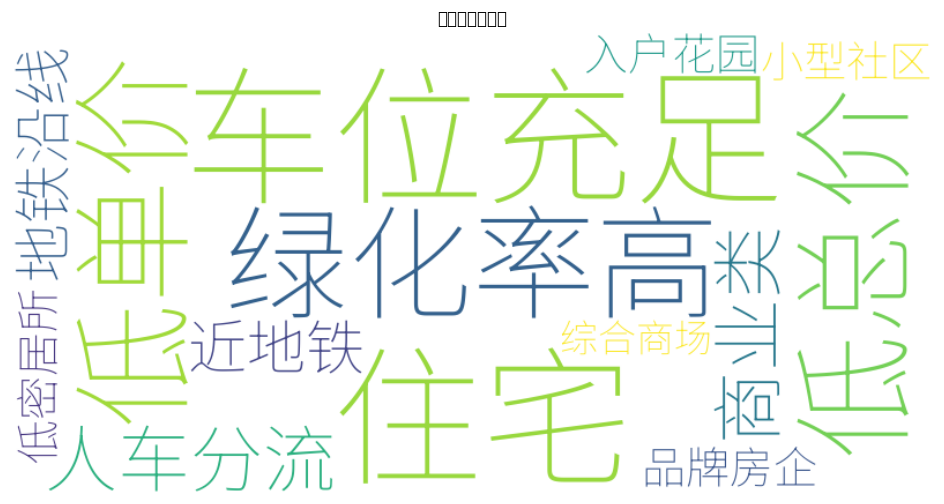

In [15]:
# 提取小区标签并统计出现次数
tags = data['标签'].str.split(',').explode()
tag_counts = Counter(tags)
print(tag_counts)

# 生成词云图,在本地运行时候font_path替换成本地字体

wordcloud = WordCloud(font_path="test.ttf",background_color='white', width=800, height=400).generate_from_frequencies(tag_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('小区标签词云图')
plt.show()

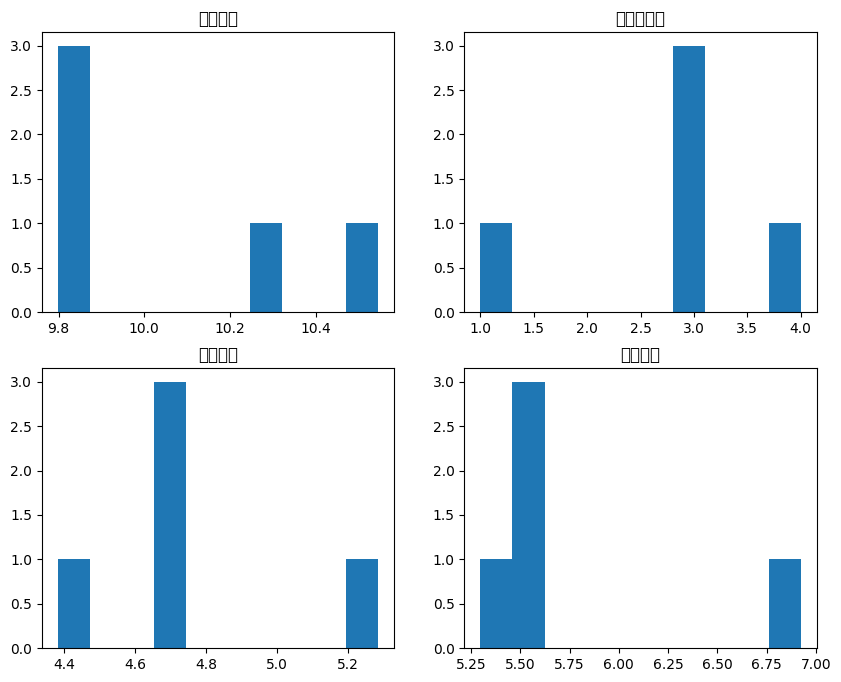

In [16]:
# 通过以上的描述分析可知【均价，总价，面积】呈现偏态分布
# 进行对数变换
data['对数均价/平方米每元'] = np.log(data['均价/平方米每元'])
data['对数总价'] = np.log(data['总价'])
data['对数面积'] = np.log(data['面积'])

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.hist(data['对数均价/平方米每元'])
plt.title('均价分布')

plt.subplot(2,2,2)
plt.hist(data['室厅数'])
plt.title('室厅数分布')

plt.subplot(2,2,3)
plt.hist(data['对数面积'])
plt.title('面积分布')

plt.subplot(2,2,4)
plt.hist(data['对数总价'])
plt.title('总价分布')

plt.show()

In [17]:
df = data.copy()

# 2. 查看标签字段的分布
标签_series = df['标签'].str.split(',')  # 如果每行只有一个标签，可以忽略这一步
标签_counts = Counter(tag.strip() for tags in 标签_series for tag in tags)
标签_counts = pd.Series(标签_counts).sort_values(ascending=False)

# 3. 筛选出现次数大于200的标签
频繁标签 = 标签_counts[标签_counts > 0].index.tolist()
print("频繁标签:", 频繁标签)

# 4. 创建新的二进制字段
df['标签列表'] = df['标签'].str.split(',')
df['标签列表'] = df['标签列表'].apply(lambda tags: [tag.strip() for tag in tags])

for 标签 in 频繁标签:
    df[f'是否是{标签}'] = df['标签列表'].apply(lambda tags: 1 if 标签 in tags else 0)

# 5. 删除临时列
df = df.drop(columns=['标签列表'])

df.sample()

频繁标签: ['住宅', '车位充足', '绿化率高', '低单价', '低总价', '人车分流', '商业类', '近地铁', '地铁沿线', '品牌房企', '入户花园', '低密居所', '小型社区', '综合商场']


,标题,地区,具体位置,类型,均价/平方米每元,室厅数,面积,标签,总价,对数均价/平方米每元,...,是否是低总价,是否是人车分流,是否是商业类,是否是近地铁,是否是地铁沿线,是否是品牌房企,是否是入户花园,是否是低密居所,是否是小型社区,是否是综合商场
1,时代印记,黄埔,广东省广州市黄埔区亨美西路,在售,18000.0,3,111.5,"住宅,低单价,低总价,绿化率高,人车分流",200.0,9.798127,...,1,1,0,0,0,0,0,0,0,0


In [18]:
df.sample()

,标题,地区,具体位置,类型,均价/平方米每元,室厅数,面积,标签,总价,对数均价/平方米每元,...,是否是低总价,是否是人车分流,是否是商业类,是否是近地铁,是否是地铁沿线,是否是品牌房企,是否是入户花园,是否是低密居所,是否是小型社区,是否是综合商场
4,北大科技园·国际科创广场,白云,石沙公路81号,待售,18000.0,3,111.0,"商业类,小型社区,近地铁,地铁沿线,综合商场",240.0,9.798127,...,0,0,1,1,1,0,0,0,1,1


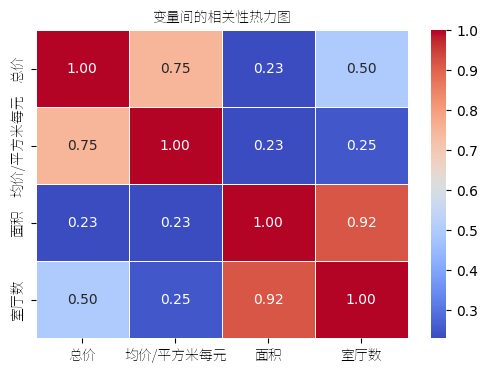

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import font_manager

# 设置中文字体
font_path = 'test.ttf'  # 替换为你的字体文件路径
font_prop = font_manager.FontProperties(fname=font_path)
#plt.rcParams['font.sans-serif'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

new_df = df[['总价','均价/平方米每元','面积','室厅数']]

corr_df = new_df.corr(method='spearman')

# 设置热力图的尺寸
plt.figure(figsize=(6, 4))

# 使用seaborn的heatmap绘制相关性矩阵
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, 
            xticklabels=corr_df.columns, yticklabels=corr_df.columns)

# 设置标题
plt.title("变量间的相关性热力图", fontproperties=font_prop)
plt.xticks(fontproperties=font_prop)
plt.yticks(fontproperties=font_prop)
plt.show()

In [20]:
print(df['对数均价/平方米每元'])

0    10.545341
1     9.798127
2     9.798127
3    10.308953
4     9.798127
Name: 对数均价/平方米每元, dtype: float64


In [21]:
from scipy.stats import chi2_contingency

class_data = ['是否是品牌房企', '是否是住宅', '是否是人车分流', '是否是车位充足', '是否是绿化率高', 
                '是否是小型社区', '是否是低总价', '是否是近地铁', '是否是地铁沿线', '是否是商业类','是否是低单价']

for i in class_data:
    contingency_table = pd.crosstab(df[i], df['对数均价/平方米每元'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    #if p < 0.05:
    print(f"{i}p值: {p}")

是否是品牌房企p值: 0.08208499862389874
是否是住宅p值: 0.32919298780790557
是否是人车分流p值: 0.32919298780790557
是否是车位充足p值: 0.32919298780790557
是否是绿化率高p值: 0.3291929878079055
是否是小型社区p值: 0.6592406302004438
是否是低总价p值: 0.3291929878079055
是否是近地铁p值: 0.32919298780790557
是否是地铁沿线p值: 0.32919298780790557
是否是商业类p值: 0.32919298780790557
是否是低单价p值: 0.3291929878079055


In [22]:
class_data = ['是否是品牌房企', '是否是住宅', '是否是人车分流', '是否是车位充足',  '是否是绿化率高', 
                '是否是小型社区', '是否是低总价', '是否是近地铁', '是否是地铁沿线', '是否是商业类','是否是低单价']

for i in class_data:
    contingency_table = pd.crosstab(df[i], df['对数总价'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    #if p < 0.05:
    print(f"{i}p值: {p}")

是否是品牌房企p值: 0.08208499862389874
是否是住宅p值: 0.32919298780790557
是否是人车分流p值: 0.3291929878079056
是否是车位充足p值: 0.3291929878079056
是否是绿化率高p值: 0.0820849986238988
是否是小型社区p值: 0.6592406302004438
是否是低总价p值: 0.3291929878079056
是否是近地铁p值: 0.32919298780790557
是否是地铁沿线p值: 0.32919298780790557
是否是商业类p值: 0.32919298780790557
是否是低单价p值: 0.3291929878079056


In [23]:
#05、建立模型—线性回归模型
data = df.copy()
data.sample()

,标题,地区,具体位置,类型,均价/平方米每元,室厅数,面积,标签,总价,对数均价/平方米每元,...,是否是低总价,是否是人车分流,是否是商业类,是否是近地铁,是否是地铁沿线,是否是品牌房企,是否是入户花园,是否是低密居所,是否是小型社区,是否是综合商场
2,国化广场,白云,广东省广州市白云区云城北二路116号,待售,18000.0,3,111.0,"商业类,车位充足,人车分流,近地铁,地铁沿线",240.0,9.798127,...,0,1,1,1,1,0,0,0,0,0


In [24]:
# 首先分析总价
# 设置自变量与因变量
X = data[['对数均价/平方米每元','对数面积','室厅数','是否是住宅','是否是车位充足','是否是绿化率高','是否是低总价','是否是低单价']]
y = data['对数总价']
X = sm.add_constant(X)

model = sm.OLS(y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   对数总价   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 05 Mar 2025   Prob (F-statistic):                nan
Time:                        17:31:03   Log-Likelihood:                 159.20
No. Observations:                   5   AIC:                            -308.4
Df Residuals:                       0   BIC:                            -310.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0929        inf         -0        n

In [25]:
# 分析均价
# 设置自变量与因变量
X = data[['对数总价','对数面积','室厅数','是否是品牌房企', '是否是住宅', '是否是人车分流', '是否是车位充足', 
            '是否是绿化率高', '是否是小型社区', '是否是低总价', '是否是近地铁', '是否是地铁沿线','是否是低单价']]
y = data['对数均价/平方米每元']
X = sm.add_constant(X)

model = sm.OLS(y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             对数均价/平方米每元   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 05 Mar 2025   Prob (F-statistic):                nan
Time:                        17:31:03   Log-Likelihood:                 160.99
No. Observations:                   5   AIC:                            -312.0
Df Residuals:                       0   BIC:                            -313.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2601        inf          0        n

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError

In [27]:
# 2. 数据预处理
X = data[['对数均价/平方米每元','对数面积','室厅数','是否是住宅','是否是车位充足','是否是绿化率高','是否是低总价','是否是低单价']].values
y = data['对数总价'].values
# 特征缩放
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 3. 构建人工神经网络
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # 输出层
])

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

# 4. 训练模型
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# # 5. 测试模型
# test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
# print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# 5. 评估模型并计算 R²
y_pred = model.predict(X_test).flatten()

# R² 计算
ss_res = np.sum((y_test - y_pred) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print(f"R²: {r2_score:.4f}")

# 6. 使用模型进行预测
predictions = model.predict(X_test[:9])
print(f"真实值: {y_test[:9]}")
print(f"预测值: {predictions.flatten()}")

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 34.4565 - mean_squared_error: 34.4565 - val_loss: 30.5976 - val_mean_squared_error: 30.5976
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 34.1758 - mean_squared_error: 34.1758 - val_loss: 30.3876 - val_mean_squared_error: 30.3876
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 33.8772 - mean_squared_error: 33.8772 - val_loss: 30.1748 - val_mean_squared_error: 30.1748
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 33.5645 - mean_squared_error: 33.5645 - val_loss: 29.9604 - val_mean_squared_error: 29.9604
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 33.2493 - mean_squared_error: 33.2493 - val_loss: 29.7452 - val_mean_squared_error: 29.7452
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.9328 - mean_squared_error: 32.9328 - val_loss: 29.5299 - val_mean_squared_error: 29.5299
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.6169 - mean_squared_error: 32.6169 - v

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,accuracy_score

In [29]:
# 设定自变量与因变量，并划分训练集与测试集
# 首先分析总价
X = data[['对数均价/平方米每元','对数面积','室厅数','是否是住宅','是否是车位充足','是否是绿化率高','是否是低总价','是否是低单价']]
Y = data['对数总价']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# 训练模型
models = RandomForestRegressor(n_estimators=50,random_state=42)
models.fit(X_train,Y_train)

# 预测测试集结果
y_pred = models.predict(X_test)

# 计算准确率
mae = mean_absolute_error(Y_test,y_pred)
mse = mean_squared_error(Y_test,y_pred)
r2 = r2_score(Y_test,y_pred)

print('mae:',mae)
print('mse:',mse)
print('r2:',r2)

mae: 0.3795617720237545
mse: 0.1756377037226854
r2: -20.134973169515995


In [30]:
# 设定自变量与因变量，并划分训练集与测试集
# 分析均价
X = data[['对数总价','对数面积','室厅数','是否是品牌房企','是否是住宅','是否是人车分流','是否是车位充足',
            '是否是绿化率高','是否是小型社区','是否是低总价','是否是近地铁','是否是地铁沿线','是否是低单价']]
y = data['对数均价/平方米每元']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

# 训练模型
models = RandomForestRegressor(n_estimators=50,random_state=42)
models.fit(X_train,Y_train)

# 预测测试集结果
y_pred = models.predict(X_test)

# 计算准确率
mae = mean_absolute_error(Y_test,y_pred)
mse = mean_squared_error(Y_test,y_pred)
r2 = r2_score(Y_test,y_pred)

print('mae:',mae)
print('mse:',mse)
print('r2:',r2)

mae: 0.39398182170509344
mse: 0.16636898709176712
r2: -19.01964272987644
